为了能够更加方便测试数据集合，比较各个算法模型的优劣，构建一个竞技场。目前主要支持4个平台的测试：

- arsenal
- sklearn
- spark mllib
- tensorflow


In [1]:
# Package imports
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

import eipi10.ml.neural_network as nn
import eipi10.ml.linear_model as lm
from eipi10.ml.planar_utils import *
from eipi10.ml.utils import *
from eipi10.test.testCases_v2 import *
from eipi10.ml.predictor import ClassificationPredictor
import logging

%matplotlib inline
pd.set_option('display.width', 100)

# 1. 数据

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset(train_data_path='./data/train_happy.h5', 
                                                                                   test_data_path='./data/test_happy.h5')

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


# 2. arsenal 

## 2.1 Logistic Regression


- 发现其实logistic regression也有不错的效果。       
train   0.951667  
test    0.926667      

train_X.shape=(12288, 600)
train_Y.shape=(1, 600)
test_X.shape=(12288, 150)
test_Y.shape=(1, 150)


INFO: Cost after epoch 0: 0.6931471806
INFO: Cost after epoch 50: 2.6680985396
INFO: Cost after epoch 100: 2.6319453443
INFO: Cost after epoch 150: 1.4179938955
INFO: Cost after epoch 200: 0.9966067073
INFO: Cost after epoch 250: 0.8353808906
INFO: Cost after epoch 300: 0.6987551618
INFO: Cost after epoch 350: 0.2405381585
INFO: Cost after epoch 400: 0.2145027340
INFO: Cost after epoch 450: 0.1444206525
INFO: Final Cost after epoch 500: 0.1326998524


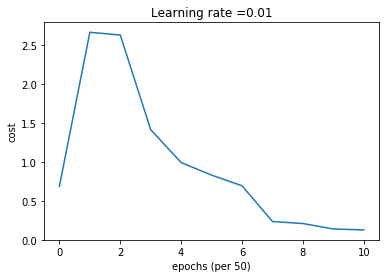

       accuracy     cost    recall  precision  specificity        f1   tp  fn  fp   tn
train  0.951667  0.13270  0.946667   0.956229     0.956667  0.951424  284  16  13  287
test   0.926667  0.23354  0.904762   0.962025     0.954545  0.932515   76   8   3   63


In [3]:
reload(lm)

train_X, train_Y = initialize_image_data(X_train_orig, Y_train_orig.T)
test_X, test_Y =  initialize_image_data(X_test_orig, Y_test_orig.T)

print("train_X.shape={}".format(train_X.shape))
print("train_Y.shape={}".format(train_Y.shape))
print("test_X.shape={}".format(test_X.shape))
print("test_Y.shape={}".format(test_Y.shape))


arsenal_lr_model = lm.LogisticRegression(num_features=train_X.shape[0], activator=Sigmoid,   
                              regularizer=L2Regularizer(0), iterator=NumberIterator(500), 
                              optimizer=GradientOptimizer(0.01), initializer=WeightInitializer(),
                              keep_cost_num_epoch=50)


arsenal_lr_model.fit(train_X, train_Y, print_cost=True, print_num_epoch=50)   
arsenal_lr_model.plot_costs()
ClassificationPredictor(arsenal_lr_model).print_metrics(train_X, train_Y, test_X=test_X, test_Y=test_Y)


## 2.2 神经网络

比起Logistic Regression, 效果提升了不错。

train  0.993333  
test   0.953333  

Step 1
* learning rate($\alpha$) 

Step 2
* $\beta $ for momentum. 0.9 is default  : 直接使用Adam了
* mini-batch size: 尝试了不同batch size, 发现性能变化不大
* hidden units：  调整神经元的个数，发现性能变化不大

Step 3
* layers   
* learning rate decay：   alpha = 0.01， mini_batch=100       
* $\beta 1,  \beta 2, \epsilon$ for Adam




In [4]:

learning_rate = 0.025

#batch
epoch_times = 500
mini_batch = 0
print_num_epoch = 50
keep_cost_num_epoch = 50

#initialize
static_weight_scale=10

#regularize
alpha = 0.01
keep_prob = 1

#optimize
beta=0.9
beta1=0.9
beta2=0.99
epsilon=1e-8

train_X, train_Y = initialize_image_data(X_train_orig, Y_train_orig.T)
test_X, test_Y =  initialize_image_data(X_test_orig, Y_test_orig.T)
# train_X, train_Y, test_X, test_Y = load_petal_dataset(num_example=2000) #增加样本，很明显提高了性能
num_neurons=[train_X.shape[0], 16, 8, 1]
activators=[Relu, Relu, Sigmoid]

In [ ]:
reload(nn)
arsenal_nn_model = nn.NeuralNetwork.build(
    num_neurons=num_neurons,
    activators=activators,      
    iterator=NumberIterator(epoch_times),
    initializer=HeWeightInitializer(),
    optimizer=nn.AdamOptimizer(learning_rate=learning_rate, beta1=beta1, beta2=beta2, epsilon=epsilon),
    keep_cost_num_epoch=keep_cost_num_epoch,
    mini_batch=mini_batch,
    regularizer=nn.L2Regularizer(alpha) ,
    keep_prob=keep_prob
)

arsenal_nn_model.fit(train_X, train_Y,  print_cost=True, print_num_epoch=print_num_epoch)
arsenal_nn_model.plot_costs()

ClassificationPredictor(arsenal_nn_model).print_metrics(train_X, train_Y, test_X=test_X, test_Y=test_Y)


INFO: Cost after epoch 0: 0.8233883420
INFO: Cost after epoch 50: 0.5076572059
INFO: Cost after epoch 100: 0.5502935858
INFO: Cost after epoch 150: 0.1445784210
INFO: Cost after epoch 200: 1.9599424738
INFO: Cost after epoch 250: 0.7064629998
INFO: Cost after epoch 300: 0.6511831872
INFO: Cost after epoch 350: 0.4116942544
INFO: Cost after epoch 400: 0.2103247130
INFO: Cost after epoch 450: 0.1159947841
INFO: Final Cost after epoch 500: 0.0853232240


# 3. sklearn

##  3.1 Logistic Regression 

参见http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

采用该版本的Logistic Regression比自己写的明显好一些，问题在哪里呢？

In [15]:
from sklearn import linear_model
from sklearn import neighbors


train_X, train_Y = initialize_image_data(X_train_orig, Y_train_orig.T)
test_X, test_Y =  initialize_image_data(X_test_orig, Y_test_orig.T)

sklearn_lr_model = linear_model.LogisticRegression(C=0.1, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logistic = sklearn_lr_model.fit(train_X.T, np.ravel(train_Y))
print(sklearn_lr_model.score(train_X.T, np.ravel(train_Y)))
print(sklearn_lr_model.score(test_X.T, np.ravel(test_Y)))


0.993333333333
0.953333333333


In [ ]:
# knn = neighbors.KNeighborsClassifier()
# knn = knn.fit(train_set_x.T, np.ravel(train_set_y))
# print(knn.score(train_set_x.T, np.ravel(train_set_y)))
# print(knn.score(test_set_x.T, np.ravel(test_set_y)))

# 3. Keras

In [2]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
# import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow


Using TensorFlow backend.


In [16]:
# GRADED FUNCTION: HappyModel

def HappyModel(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    ### START CODE HERE ###
    # Feel free to use the suggested outline in the text above to get started, and run through the whole
    # exercise (including the later portions of this notebook) once. The come back also try out other
    # network architectures as well. 
    
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')

    ### END CODE HERE ###
    
    return model

In [32]:
keras_nn_model = HappyModel(X_train.shape[1:])
keras_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
keras_nn_model.fit(X_train, Y_train, epochs=30, batch_size=32)

Epoch 1/30
600/600 [==============================] - 8s 13ms/step - loss: 1.5510 - acc: 0.6317
Epoch 2/30
600/600 [==============================] - 8s 13ms/step - loss: 0.3319 - acc: 0.8583
Epoch 3/30
600/600 [==============================] - 8s 13ms/step - loss: 0.1827 - acc: 0.9267
Epoch 4/30
600/600 [==============================] - 8s 13ms/step - loss: 0.1434 - acc: 0.9333
Epoch 5/30
600/600 [==============================] - 8s 13ms/step - loss: 0.1440 - acc: 0.9450
Epoch 6/30
600/600 [==============================] - 8s 13ms/step - loss: 0.0923 - acc: 0.9700
Epoch 7/30
600/600 [==============================] - 8s 13ms/step - loss: 0.0855 - acc: 0.9800
Epoch 8/30
600/600 [==============================] - 8s 13ms/step - loss: 0.0620 - acc: 0.9850
Epoch 9/30
600/600 [==============================] - 8s 13ms/step - loss: 0.0741 - acc: 0.9750
Epoch 10/30
600/600 [==============================] - 8s 13ms/step - loss: 0.0606 - acc: 0.9867
Epoch 11/30
600/600 [==================

In [39]:
preds = keras_nn_model.evaluate(X_test, Y_test, batch_size=32)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 1s 7ms/step
Loss = 0.105898136695
Test Accuracy = 0.939999997616


# 模型比较

## 图片测试

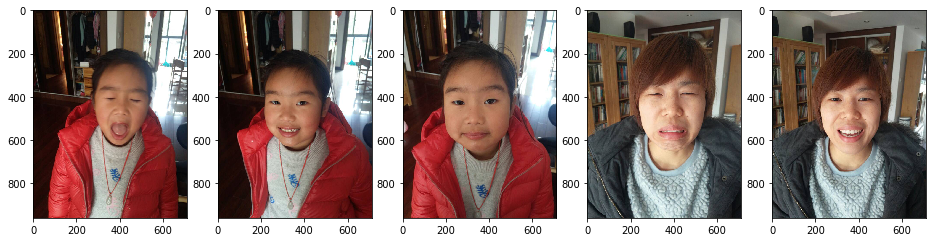

In [27]:
img_paths = ['image/xxw_cry.jpg', 'image/xxw_smile.jpg', 'image/xxw_smile1.jpg', 'image/yxh_cry.jpg', 'image/yxh_smile.jpg']

plt.figure(num='family',figsize=(16, 16))  

i = 0    

for img_path in img_paths:    
    i = i + 1
    plt.subplot(1,len(img_paths),i)  
    img = image.load_img(img_path)
    imshow(img)

    

In [34]:
model_predict = []

for img_path in img_paths:
    img = image.load_img(img_path, target_size=(64, 64))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x_tensor = preprocess_input(x)
    x_flatten, y_flatten =  initialize_image_data(x, None)
    
    model_predict.append([np.int(ClassificationPredictor(arsenal_lr_model).predict(x_flatten)),
                          np.int(ClassificationPredictor(arsenal_lr_model).predict(x_flatten)),
                          np.int(sklearn_lr_model.predict(x_flatten.T)),
                          np.int(keras_nn_model.predict(x_tensor))
                         ])

model_predict = pd.DataFrame(model_predict, index=img_paths,
                             columns=['arsenal_lr_model', 'arsenal_lr_model', 'sklearn_lr_model', 'keras_nn_model'])
model_predict

,arsenal_lr_model,arsenal_lr_model,sklearn_lr_model,keras_nn_model
image/xxw_cry.jpg,1,1,1,1
image/xxw_smile.jpg,1,1,1,1
image/xxw_smile1.jpg,1,1,1,1
image/yxh_cry.jpg,0,0,0,1
image/yxh_smile.jpg,0,0,0,1


从结果来看，错误率还挺高的。其原因在于数据的不同分布造成的吗？另外keras的结果看起来和其他明显不同。接下来还要尝试更多的算法。